Generating random values for the volume function over time didnt work yet, because the function depends basically not on a constant parameter, but on the total feed into the reactor, which doesnt have a pattern or constant value. 

--> next approach: try with CO2, because here i have Yco2/x as a constant, that i could change randomly. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from E_model import model_S_no2
from E_model import show_plot_no2

pd.options.mode.chained_assignment = None  # Suppress the warning

In [2]:
df_exp = pd.read_csv('data/batch_no2/data_combined.csv')

In [3]:
num_samples = 500
sigma_big = 0.1
sigma_small = 0.001
sigma_co2 = 0.0001
p = [0.441, 0.003, 1.603, 0.651, 0.0451, 0.175]

Yxs_dist = np.random.normal(p[0], sigma_big, num_samples)
Yco2s_dist = np.random.normal(p[1], sigma_co2, num_samples)
qs_max_dist = np.random.normal(p[2], sigma_big, num_samples)
Ks_dist = np.random.normal(p[3], sigma_big, num_samples)
m_s_dist = np.random.normal(p[4], sigma_small, num_samples)
lag_dist = np.random.normal(p[5], sigma_small, num_samples)

df_p = pd.DataFrame({
    'Yxs': Yxs_dist,
    'Yco2s': Yco2s_dist,
    'qs_max': qs_max_dist,
    'Ks': Ks_dist,
    'm_s': m_s_dist,
    'lag': lag_dist})

df_p.describe()

,Yxs,Yco2s,qs_max,Ks,m_s,lag
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.435145,0.003001,1.595294,0.651735,0.045099,0.174992
std,0.093586,0.000104,0.103969,0.098983,0.001034,0.000976
min,0.167734,0.002668,1.312403,0.333318,0.041583,0.172101
25%,0.366022,0.002939,1.520661,0.582473,0.044493,0.174349
50%,0.436361,0.003001,1.594185,0.646168,0.045106,0.175041
75%,0.504222,0.003060,1.664099,0.722661,0.045741,0.175617
max,0.746797,0.003294,1.911476,0.961954,0.048128,0.177694


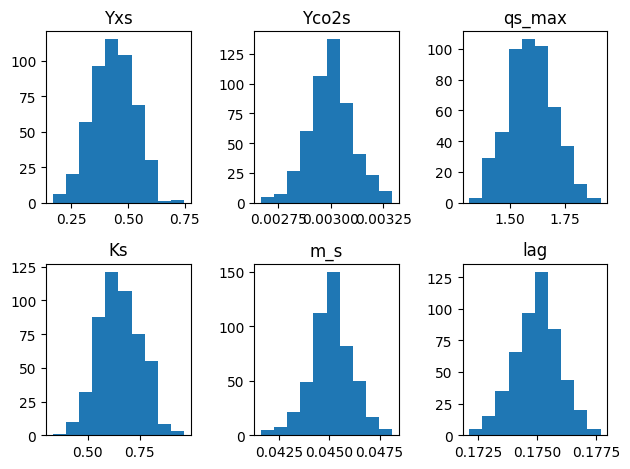

In [4]:
# check if there are enough samples to have a normal distribution
fig, ax = plt.subplots(2, 3)
ax[0,0].hist(df_p['Yxs'])
ax[0,0].set_title('Yxs')
ax[0,1].hist(df_p['Yco2s'])
ax[0,1].set_title('Yco2s')
ax[0,2].hist(df_p['qs_max'])
ax[0,2].set_title('qs_max')
ax[1,0].hist(df_p['Ks'])
ax[1,0].set_title('Ks')
ax[1,1].hist(df_p['m_s'])
ax[1,1].set_title('m_s')
ax[1,2].hist(df_p['lag'])
ax[1,2].set_title('lag')
plt.tight_layout()

In [5]:
# Set the noise parameters
mean = 0  # Mean of the noise
std_dev = 0.1  # Standard deviation of the noise
std_dev_co2 = 0.001  # Standard deviation of the noise

In [6]:
# define sample frequency
# --> higher frequency reduces the amount of data that has to be stored (less data points)
delta_t = 2 #min

df_batches = pd.DataFrame()
for i in range(df_p.shape[0]):
    batch_id = str(i).zfill(3)
    list_p = list(df_p.iloc[i])
    df = model_S_no2(list_p, delta_t)
    df['batch_id'] = str(batch_id)
    
    # Add noise to the 'biomass' column
    noise_biomass = np.random.normal(mean, std_dev, df.shape[0])
    df['biomass'] += noise_biomass

    # Add noise to the 'co2' column
    noise_co2 = np.random.normal(mean, std_dev_co2, df.shape[0])
    df['co2'] += noise_co2
    
    # Add noise to the 'glucose' column
    noise_glucose = np.random.normal(mean, std_dev, df.shape[0])
    df['glucose'] += noise_glucose

    df_batches = pd.concat([df_batches, df], ignore_index=True)

df_batches.to_csv('data/batch_no2/generated data/df_gen_co2_1.csv')

In [7]:
df_gen = pd.read_csv('data/batch_no2/generated data/df_gen_co2_1.csv')
df_gen.drop(['Unnamed: 0'], axis=1, inplace=True)
df_gen['batch_id'] = df_gen['batch_id'].astype(str).str.zfill(3)

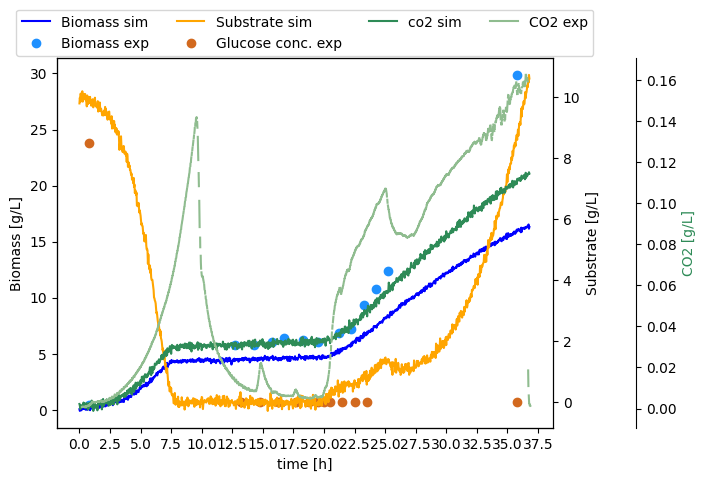

In [8]:
df_one = df_gen[df_gen['batch_id'] == '110']
show_plot_no2(df_one)

In [9]:
# biomass
df_X = df_gen.copy().drop(['glucose', 'co2'], axis=1)
sorted_X = df_X.groupby('batch_id')['biomass'].max().sort_values(ascending=False).index
df_X['batch_id'] = pd.Categorical(df_X['batch_id'], categories=sorted_X, ordered=True)
df_X = df_X.sort_values(['batch_id', 'time'], ascending=[True, True])

# glucose
df_S = df_gen.copy().drop(['biomass', 'co2'], axis=1)
sorted_S = df_S.groupby('batch_id')['glucose'].max().sort_values(ascending=False).index
df_S['batch_id'] = pd.Categorical(df_S['batch_id'], categories=sorted_S, ordered=True)
df_S = df_S.sort_values(['batch_id', 'time'], ascending=[True, True])

# co2
df_co2 = df_gen.copy().drop(['biomass', 'glucose'], axis=1)
sorted_qs = df_co2.groupby('batch_id')['co2'].max().sort_values(ascending=False).index
df_co2['batch_id'] = pd.Categorical(df_co2['batch_id'], categories=sorted_qs, ordered=True)
df_qs = df_co2.sort_values(['batch_id', 'time'], ascending=[True, True])

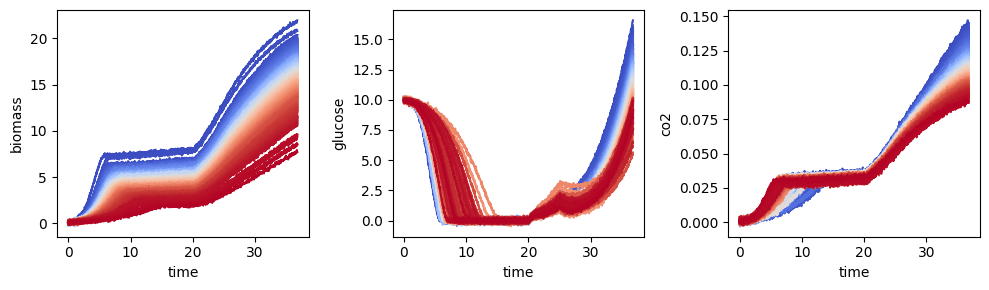

In [10]:
# Rainbow palette: Spectral
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

sns.lineplot(ax=ax[0], data=df_X, x='time', y='biomass', hue='batch_id', palette='coolwarm', legend=False)
sns.lineplot(ax=ax[1], data=df_S, x='time', y='glucose', hue='batch_id', palette='coolwarm', legend=False)
sns.lineplot(ax=ax[2], data=df_co2, x='time', y='co2', hue='batch_id', palette='coolwarm', legend=False)

plt.tight_layout()
plt.show()